<a href="https://colab.research.google.com/github/brunopiruka/neurocientista.com.br/blob/master/Previs%C3%A3o_de_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](https://raw.githubusercontent.com/brunopiruka/neurocientista.com.br/master/dataset/logo.png)

*por [Bruno_piruka](https://neurocientista.com.br/)*

---

#Previsão de Evasão de Clientes *(Churn Rate)*

Nós, que de alguma forma, dependemos de uma base de clientes para a manutenção do funcionamento de um negócio. Precisamos - periodo a periodo - prever não só o potencial aumento da base de clientes, mas principalmente a potencial diminuição dessa base.

Isso é o que usualmente se chama de *churn rate*, ou seja, qual a taxa de abandono de clientes de sua base.

![alt text](https://image.freepik.com/vetores-gratis/anuncio-de-eventos-cancelados_52683-39092.jpg)

Nesse projeto, vou juntar duas coisas que gosto muito e mostrar como as neurociências e ciência de dados andam juntas!

Não só podemos buscar compreender o comportamento humano relacionado ao consumo, como também utilizar de modelos preditivos de *machine learning* para guiar nossas estratégias de forma mais assertiva.


#Origem dos Dados

Os dados utilizados para esse projeto foram disponilizados pela IBM, em sua plataforma de ensino - [IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#) - sendo um dataset genérico de uma companhia de telecomunicações. O dataset completo pode ser consultado nesse [link](https://raw.githubusercontent.com/brunopiruka/neurocientista.com.br/master/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv)

Porém, o entedimento que iremos extrair dessa análise pode ser extrapolado para qualquer serviço de assinatura, por exemplo, desde telefonia até serviços de *Streaming* de áudio e vídeo

##Importando os Dados

In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Random seed
np.random.seed(42)

# importar os dados
DADOS = 'https://raw.githubusercontent.com/brunopiruka/neurocientista.com.br/master/dataset/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(DADOS)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


Em uma primeira olhada, conseguimos indentificar alguma lógica no nome das colunas e relacionar com atividades e serviços providos por operadoras de telefonia.

Vamos agora ver o tamanho do dataset

In [2]:
# Visualizando o tamanho do dataser
print('Número de Linhas:\t', df.shape[0])
print('Número de Colunas:\t', df.shape[1])

Número de Linhas:	 7043
Número de Colunas:	 21


## Análise Exploratória dos Dados

O ínicio da analise se dá pela busca de valores ausentes, identificação das colunas, número de entradas distintas e tipos das entradas

In [3]:
print ('Quantidade de dados ausentes:', df.isnull().sum().values.sum())
print('\nNomes da Colunas e tipo das variáveis:\n{}'.format(df.dtypes))
print('\nValores únicos por coluna:\n{}'.format(df.nunique()))

Quantidade de dados ausentes: 0

Nomes da Colunas e tipo das variáveis:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Valores únicos por coluna:
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       

Dessa primeira análise, já encontramos alguns pontos para serem trabalhados:

*  A coluna `TotalCharges` é tipo `object`, portanto, deveremos transformá-la para  `float`.
* Apesar da análise não retornar valores ausentes, aparentemente, existem strings que representam esses valores.
* Já conseguimos identificar nossa variável alvo `Churn`.
* Existem várias variáveis binárias e categóricas que precisarão ser convertidas para valores numéricos.
* A coluna `customerID` não possui relevância para a análise, uma vez que é apenas um identificador de cada cliente, portanto, será descartada.

Iniciaremos realizando a conversão do tipo para a coluna `TotalCharges` e descartando a coluna `customerID`:

In [4]:
def conv_str_float(entrada):
  '''
  Converte os objetos do tipo string para o tipo float.

  # Argumentos
    entrada: string, string da coluna TotalCharges.

  # Saídas
    Valor convertido em float, caso seja possível a conversão.
    NaN, caso retorne erro.
  
  '''
  try:
    return float(entrada)
  except ValueError:
    return np.nan

# Criar cópia do dataframe para tratamento
df_clean = df.copy()

# Remover a columa customerID
df_clean.drop('customerID', axis=1, inplace=True)

# Converter a variável TotalCharges para float
df_clean['TotalCharges'] = df_clean['TotalCharges'].apply(conv_str_float)



In [5]:
# Verificar dados ausentes em TotalCharges:
print('Dados Ausentes em TotalCharges:', df_clean.TotalCharges.isnull().sum())

Dados Ausentes em TotalCharges: 11


Uma vez transformada a variável `TotalCharges` para o tipo `float`e idenficada a existência de dados ausentes, iremos atribuir o valor da média para suprir as ausências.

In [6]:
# Substituindo os dados ausentes pelo valor da média:

df_clean.TotalCharges.fillna(df_clean.TotalCharges.median(), inplace=True)
print('Dados Ausentes em TotalCharges:', df_clean.TotalCharges.isnull().sum())

Dados Ausentes em TotalCharges: 0


Antes de prosseguirmos com o tratamento e análise, iremos análiser a possível presença de *outliers* que possam distorcer os próximos passos.

In [7]:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Como podemos ver pelo `describe`, não existem valores destoando estatísticamente, que poderiam estar distorcendo a média e desvio padrão.

De qualquer forma, é interessante plotar uma visualização em *boxplot* de modo a reforçar essas informações.

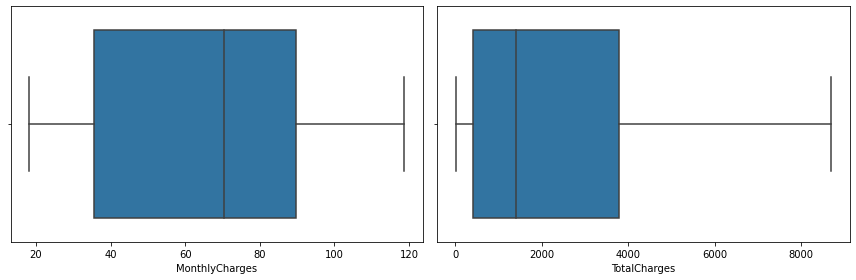

In [8]:
# Plotando boxplot para as colunas MonthlyCharges e TotalCharges

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
sns.boxplot(df_clean['MonthlyCharges'], ax=ax[0])
sns.boxplot(df_clean['TotalCharges'], ax=ax[1])
plt.tight_layout()

Como podemos ver, de fato, não existem valores que fujam dos limites superiores ou inferiores nas respectivas *boxplots*.

Uma das variáveis que ainda não análisamos é a coluna `tenure`, ao que tudo indica, ela se refere à fidelidade, ou seja, a quanto tempo já está na base de clientes. 

Como não existe uma indicação explicita será pressuposto que a unidade de medida são os meses.

Vamos avaliar graficamente a variável.

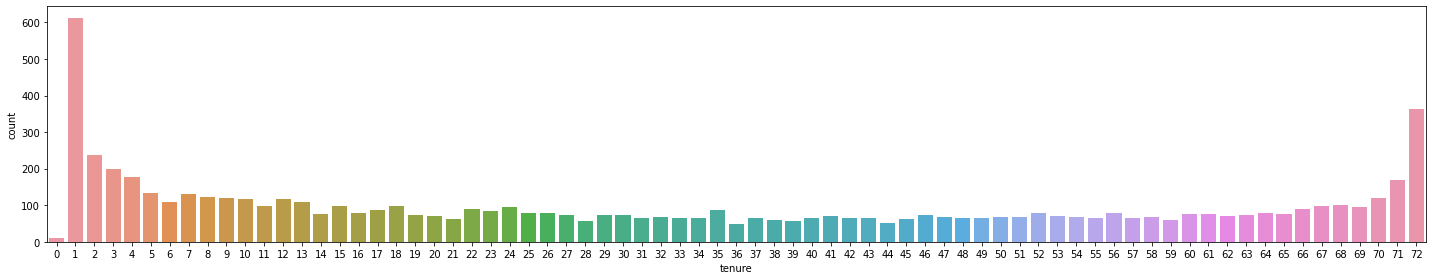

In [9]:
# Plotando um gráfico counter plot para a variável

fig, ax = plt.subplots(figsize=(20,4))
sns.countplot(df_clean['tenure'])
plt.tight_layout()

De forma ilustrativa iremos avaliar o balanceamento em relação ao gênero, homens e mulheres, em nosso caso não existe evidência que isso gere qualquer tipo de viés, de qualquer forma, em muitos casos pode ser um fator relevante.

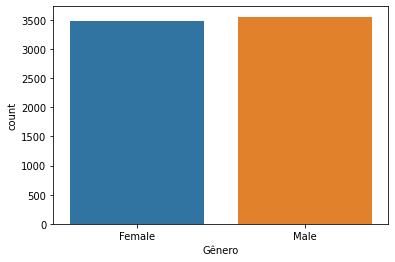

In [10]:
# Plotando um gráfico countplot de gêneros

sns.countplot(df_clean.gender)
plt.xlabel('Gênero')
plt.show()

É importante também avaliar o balanceamento do dataset, levando em conta a distribuição de nossa variável alvo, no caso `Churn`, onde os valores possíveis são `Yes`ou `No`.

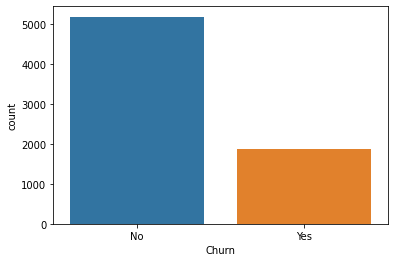

In [11]:
#Plotando um gráfico contplot

sns.countplot(df_clean.Churn)
plt.show()

É perceptível um desbalanceamento dos resultados, onde `No` aparece quase três veze mais que `Yes`, portanto, será feito o balanceamento em momento oportuno.

## Preparando os Dados

Após a análise exploratória inicial, é chegada a hora de preparar os dados visando a contrução de nosso modelo preditivo de *Machine Learning*

O primeiro passo será separar as variáveis categóricas e numéricas, depois, converter as variáveis categóricas para valores numéricos de forma a permitir a construção de nosso modelo. Para tal utilizaremos a função `LabelEncoder` para as variáves categóricas binárias e a função `get_dummies` para as variáveis categóricas não binárias.

In [12]:
# pré processar as variáveis
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# criar uma cópia do dataframe
df_proc = df_clean.copy()

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Encoding para colunas categóricas com múltiplas classes
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# ver as 5 primeiras entradas do novo dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,0,1,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0


## Contruindo o modelo de *Machine Learning*

Uma vez com nossas variáveis transformadas, podemos iniciar a construção de nosso modelo de *Machine Learning*

Nesse primeiro momento será feito apenas uma construção "básica" sem ajustes nem balanceamento, servindo como ponto de partida.

A primeira etapa é a separação do dataframe em treino e teste.

In [13]:
# separar a feature matrix da target vector
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# dividir os dados entre treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y)

Utilizando cross-validation podemos estimar o erro dos modelos iniciais e balizar nossos ajustes. Avaliaremos o valor do atributo `recall` para pautar nossas decisões.

In [14]:
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()


Iniciaremos utilizando Random Forest, sem ajustes de parâmetros.

In [15]:
# criar baseline e ver desempenho
rf = RandomForestClassifier()
score_baseline = val_model(X_train, y_train, rf)

Recall: 0.47 (+/- 0.02)


Agora partindo no modelo base podemos iniciar os ajustes e avaliar a melhora ou ou piora do desempenho.

Primeiramente iremos padronizar os valores antes de realizar o balancemento.

Portanto nossa sequência será usar o `StandarScaler` e posteriormente o `RandomUnderSampler`.

In [16]:
# Padronizar os dados
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Balanceando os dados

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_sample(X_train, y_train)



Aplicando a validação cruzada a vários modelos, podemos avaliar o desempenho e escolher com base nos que se mostram melhores. Para tal usaremos os seguintes modelos:

* Random Forest
* Decision Tree
* Stochastic Gradient Descent
* SVC
* Regressão Logística
* LightGBM

In [17]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []
# avaliar o desempenho (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.769784
DecisionTreeClassifier,0.681295
SGDClassifier,0.733813
SVC,0.790647
LogisticRegression,0.807194
XGBClassifier,0.805036
LGBMClassifier,0.766187


Dadas as características do problema e o desempenho durante as execuções anteriores, optei pelo XGBoost, praticamente empatado com a Regressão Logística.

Meu entendimento é que o tuning dos parâmetros pode melhorar ainda mais a qualidade da solução. Como temos poucos ajustes possíveis na Regressão Logística, não acredito que o resultado poderia passar o XGBoost.

## Otimização dos Hiperparâmetros

XGBoost possui inúmeros parâmetros. Alguns afetam mais a qualidade do modelo, outros menos. Uma boa prática é definir uma taxa de aprendizado e número de estimadores, realizar tuning de outros parâmetros e, no final, checar outras taxas de aprendizado.

Abaixo, irei ajustar o número de estimadores. O modelo foi instanciado com a `learning_rate=0.1`.

In [18]:
xgb = XGBClassifier(learning_rate=0.1)

param_grid = {
 'n_estimators':range(0,1000,50),
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8107913669064748 para {'n_estimators': 50}


Com o número de estimadores igual a 50, realizarei a busca pelos parâmtros 

---

`max_depth` e `min_child_weight`.

In [19]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50)

param_grid = {
 'max_depth':range(1,8,1),
 'min_child_weight':range(1,5,1)
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8237410071942446 para {'max_depth': 1, 'min_child_weight': 1}


Obtidos os valores de max_depth=1 e min_child_weight=1, irei otimizar o parâmetro gamma.



In [20]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=50, max_depth=1, min_child_weight=1)

param_grid = {
 'gamma':[i/10.0 for i in range(0,5)]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8187050359712231 para {'gamma': 0.0}


Por fim, obtido `gamma=0`, vou testar quatro valores para a `learning_rate` e ver qual oferece o melhor resultado.

In [21]:
xgb = XGBClassifier(n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)

param_grid = {
 'learning_rate':[0.001, 0.01, 0.1, 1]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8812949640287769 para {'learning_rate': 0.001}


Fato é que uma taxa de aprendizado menor, conseguiu melhorar o desempenho do modelo XGBoost, considerando `recall` como sendo a única métrica de importância (premissa assumida por este autor).

Agora, treina-se o modelo em cima do dataset de treino completo, e verifica-se o desempenho final em cima dos dados de teste, no seu primeiro contato com esse sub-conjunto que havia sido preservado.

              precision    recall  f1-score   support

           0       0.94      0.57      0.71      1282
           1       0.44      0.90      0.59       479

    accuracy                           0.66      1761
   macro avg       0.69      0.73      0.65      1761
weighted avg       0.80      0.66      0.68      1761

AUC: 0.7336



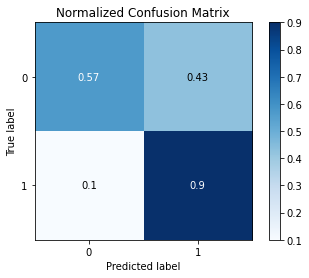

In [22]:
# modelo final
xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50, max_depth=1, min_child_weight=1, gamma=0.0)
xgb.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

## Conclusões

Os dados de testes não haviam sido passados para o modelo ainda. No entanto, ele manteve um desempenho próximo àquele estimado anteriormente, graças a um bom trabalho de otimização nos parâmetros.

Ainda há espaço para se tentar outras técnicas de balanceamento de dados e também técnicas de machine learning como feature engineering e feature selection.